# Importing the important libraries

In [1]:
import pandas
import pandas as pd
import numpy
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import numpy as np
import time
import sklearn
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# fix random seed for reproducibility
plt.rcParams['figure.figsize'] = (15, 6)
from sklearn.datasets.samples_generator import make_blobs
from pandas.tools.plotting import parallel_coordinates

# Data Set

## Load the dataset

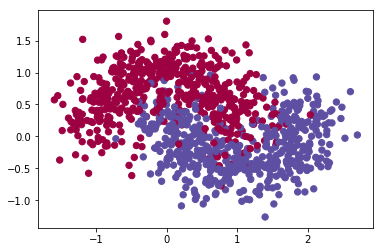

In [2]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.30)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

## Peprocess the data

In [3]:
df = pandas.DataFrame(X,y)

## Prepare the data for classification

In [4]:
dataset = df.values

In [5]:
from sklearn import preprocessing
# for training data
X = dataset.astype(float)
features = preprocessing.scale(X)
target = y

In [6]:
X.shape

(1000, 2)

## Feature Selection

In [7]:
from sklearn.model_selection import train_test_split
# Extracting 20% validation data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0, random_state=17)

## Preproccing

In [8]:
print('Number of training examples',len(X_train))
print('Number of validation examples',len(X_test))

Number of training examples 1000
Number of validation examples 0


In [9]:
from sklearn import preprocessing
# normalize the data attributes
X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)
# standardize the data attributes
X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

# Neural Networks

In [10]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.utils import np_utils
N1 = 3
N2 = 4
labelsTrain = np_utils.to_categorical(y_train)
model = Sequential()
model.add(Dense(N1,
                input_shape=(2,), 
                activation="relu"))
model.add(Dense(N2, activation='relu'))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
start_time = time.time()
model.fit(X_train, labelsTrain, verbose=0, batch_size=1, epochs=100)
print("The time for training NN is  %s seconds " % (time.time() - start_time))
loss, accuracy = model.evaluate(X_train, labelsTrain, batch_size=1, verbose=0)
print("Test fraction correct (NN-loss) = {:.2f}".format(loss))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

Using TensorFlow backend.


ModuleNotFoundError: No module named 'google.protobuf'

In [ ]:
modelBuckup = model

## The Architecture of the Model

In [37]:
modelBuckup.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


# Direct Method for Pruning Weights

## Pruning the weights

In [38]:
startD = time.time()
N_arry = np.zeros((N1*N2))
N_arryD = np.zeros((N1*N2))
noExamples = 100
NL = np.zeros(noExamples)
Threshold = 0
constant=1
for k in range(noExamples):
    count = 0
    for i in range(N1):
        for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[k:k+1], labelsTrain[k:k+1], 
                                                 batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[k:k+1], labelsTrain[k:k+1], 
                                                         batch_size=1, verbose=0)
            delta = loss_New - loss
            #reward = max(0,Threshold + delta)/constant
            #print('delta = ', delta)
            All_weights[2][i][j]= temp  # before
            N_arry[count] = max(delta,0) 
            count = count +1
            modelBuckup.set_weights(All_weights)
                #print(delta)
    NL[k]=np.argmax(N_arry)
    N_arryD = N_arryD + N_arry
endD = time.time()
print("Execution time ",endD - startD)

Execution time  2.8614022731781006


In [39]:
N_arryD

array([1.31166279e-02, 1.01563927e+01, 5.17908359e+00, 1.57072103e+00,
       1.23288453e-01, 5.31098656e+00, 1.15943347e+01, 4.06044364e-01,
       3.03464778e-01, 3.80908218e+01, 2.58717200e+00, 1.31657064e+00])

## The single weight that has been chosen by direct method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [40]:
reshapeD = N_arryD.reshape(N1,N2)
D = np.argmax(N_arryD)
Di,Dj = np.unravel_index(D, reshapeD.shape)
print("The index of chosen  W_ji is = ", Dj, Di)

The index of chosen  W_ji is =  1 2


# Epsilon Greedy

## Pruning the Weights

In [41]:
Round = 500  # will the same for all methods

In [42]:
startG = time.time()
N_arry = np.zeros(N1*N2)
noExamples = 100
NL = np.zeros(noExamples)
ep = np.zeros(Round)
Avg_Accumaltive_R_EGN = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_R_EGN.reshape(N1,N2)
Count_EGN = np.ones(N1*N2)
import random
epsilon=0.5
count = 0
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_R_EGN[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1+N2-1, noExamples):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            if (epsilon>random.uniform(0, 1)):
                ind = np.argmax(Avg_Accumaltive_R_EGN)
            else:
                ind = random.randint(0,N1*N2-1)
            i,k = np.unravel_index(ind, p_reshape.shape)
            #print(i,k)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0
            modelBuckup.set_weights(All_weights)
            Count_EGN[ind]=Count_EGN[ind]+1
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            #print(delta)
            reward = max(0,Threshold + delta)/constant
            #print(reward)
            val = Count_EGN[ind]
            Avg_Accumaltive_R_EGN[ind] = (val-1)/val * Avg_Accumaltive_R_EGN[ind] + 1/val * reward
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            ep[j]=ind
endG = time.time()
print("Execution time ",endG - startG)

Execution time  0.3526778221130371


In [43]:
Avg_Accumaltive_R_EGN

array([0.        , 0.1863535 , 0.06624321, 0.00372873, 0.00202962,
       0.13170159, 0.09627201, 0.        , 0.00141146, 0.39973066,
       0.        , 0.00325037])

## The single weight that has been chosen by Epsilon Greedy method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [44]:
reshapeG = Avg_Accumaltive_R_EGN.reshape(N1,N2)
G = np.argmax(Avg_Accumaltive_R_EGN)
Gi,Gj = np.unravel_index(G, reshapeG.shape)
print("The index of chosen  W_ji is = ", Gj, Gi)

The index of chosen  W_ji is =  1 2


# UCB1

## Pruning Weights

In [45]:
startU = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(noExamples)
Avg_Accumaltive_UCB = np.zeros(N1*N2)
Count_UCB = np.ones(N1*N2)
UCB1 = np.zeros(Round)
p_reshape = Avg_Accumaltive_UCB.reshape(N1,N2)
count = 0
import random
tau=4
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][j]= temp
            Avg_Accumaltive_UCB[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1+N2-1, noExamples):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            padding = np.sqrt(2*Count_UCB.sum()/Count_UCB)
            ucb = Avg_Accumaltive_UCB + padding
            ind = np.argmax(ucb)
            Count_UCB[ind] = Count_UCB[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0           
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            reward = max(0,Threshold + delta)/constant
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)
            val = Count_UCB[ind]
            Avg_Accumaltive_UCB[ind] = (val-1)/val * Avg_Accumaltive_UCB[ind] + 1/val * reward
            modelBuckup.set_weights(All_weights)
            UCB1[j]=ind
endU = time.time()
print("Execution time ",endU - startU)

Execution time  0.3960721492767334


In [46]:
Avg_Accumaltive_UCB

array([0.        , 0.08526209, 0.09509815, 0.00414303, 0.        ,
       0.02552316, 0.03488057, 0.        , 0.00106808, 0.38007941,
       0.00798247, 0.0476514 ])

## The single weight that has been chosen by UCB1 method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [47]:
reshapeU = Avg_Accumaltive_UCB.reshape(N1,N2)
U = np.argmax(Avg_Accumaltive_UCB)
Ui,Uj = np.unravel_index(U, reshapeU.shape)
print("The index of chosen  W_ji is = ", Uj, Ui)

The index of chosen  W_ji is =  1 2


# Thompson Sampling

## Pruning weights

In [48]:
startT = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(noExamples)
Avg_Accumaltive_TS = np.zeros(N1*N2)
Count_TS = np.ones(N1*N2)
TS = np.zeros(Round)
p_reshape = Avg_Accumaltive_TS.reshape(N1,N2)
count = 0
success = np.zeros(N1*N2)
failure = np.zeros(N1*N2)
for i in range(N1): 
    for j in range(N2):
            loss, accuracy = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
        # Prune the neuron in the layer
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][j]
            All_weights[2][i][j] = 0 
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[1:10], labelsTrain[1:10], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1                        
            All_weights[2][i][j]= temp
            Avg_Accumaltive_TS[count] = reward
            modelBuckup.set_weights(All_weights)
            count = count+1
for j in range(N1+N2-1, noExamples):
            b = random.randint(0,noExamples-1)  
            loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
        # Prune the neuron in the layer 
            ind = np.argmax(np.random.beta(1+success, 1+failure))
            Count_TS[ind] = Count_TS[ind] + 1
            i,k = np.unravel_index(ind, p_reshape.shape)
            All_weights=modelBuckup.get_weights()
            temp = All_weights[2][i][k]
            All_weights[2][i][k] = 0                     
            modelBuckup.set_weights(All_weights)
            loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
            delta = loss_New - loss
            if(delta>0):
                reward = 1
                success[i] = success[i]+1
            else:
                reward = 0
                failure[i] = failure[i]+1            
            All_weights[2][i][k] = temp
            modelBuckup.set_weights(All_weights)          
            val = Count_TS[ind]
            Avg_Accumaltive_TS[ind] = (val-1)/val * Avg_Accumaltive_TS[ind] + 1/val * reward
            TS[j]=ind
endT = time.time()
print("Execution time ",endT - startT)

Execution time  0.35758185386657715


In [49]:
Avg_Accumaltive_TS

array([0.        , 1.        , 1.        , 0.3       , 0.07692308,
       0.5       , 0.41666667, 0.        , 0.5       , 0.71428571,
       0.1       , 0.25      ])

## The single weight that has been chosen by Thompson Sampling method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [50]:
reshapeT = Avg_Accumaltive_TS.reshape(N1,N2)
T = np.argmax(Avg_Accumaltive_TS)
Ti,Tj = np.unravel_index(T, reshapeT.shape)
print("The index of chosen  W_ji is = ", Tj, Ti)

The index of chosen  W_ji is =  1 0


# Successive Rejects

For a K-armed bandit, Successive Rejects operates in (K − 1) phases. At the end of each phase, the arm with the lowest average reward is discarded. Thus, at the end of phase (K − 1) only one arm survives, and this arm is recommended.


## Pruning weights

In [51]:
startS = time.time()
N_arry = np.zeros(N1*N2)
NL = np.zeros(noExamples)
sr = []
Avg_Accumaltive_SR = np.zeros(N1*N2)
Avg_Accumaltive_SR2 = np.zeros(N1*N2)
Avg_Accumaltive_SR1 = np.zeros(N1*N2)
p_reshape = Avg_Accumaltive_SR2.reshape(N1,N2)
check_array = np.ones((N1,N2))
Count_SR = np.ones(N1*N2)
A = [0]
Nk = []
K = N1*N2
Log = 0.5
for k in range(K):
    d = k+2
    Log = Log + 1/d
for k in range(K-2):
    d = k+1
    A.append(int(np.floor(1/Log * (Round-K)/(K+1-d))))
A.sort(reverse=False)
#print("The round of the phases : ",A)
g=0
for a in A:
    h = a - g
    g = a
    Nk.append(h)
    count=0
    #print(a)
    for n in range(h):
        c=0
        for i in range(N1):
            for j in range(N2):
                if check_array[i][j]==1:
                    b = random.randint(0,noExamples-1) 
                    loss, accuracy = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
                    All_weights=modelBuckup.get_weights()
                    temp = All_weights[2][i][j]
                    All_weights[2][i][j] = 0
                    modelBuckup.set_weights(All_weights)
                    loss_New, accuracy_New = modelBuckup.evaluate(X_train[b:b+1], labelsTrain[b:b+1], batch_size=1, verbose=0)
                    delta = loss_New - loss
                    reward = max(0,Threshold + delta)/constant
                    All_weights[2][i][j] = temp
                    modelBuckup.set_weights(All_weights)
                    val = Count_SR[c]
                    #print(reward)
                    Avg_Accumaltive_SR[c] = (val-1)/val * Avg_Accumaltive_SR[c] + 1/val * reward
                    temp = All_weights[2][i][j]
                    count = count+1
                    c = c + 1    
        Avg_Accumaltive_SR2=Avg_Accumaltive_SR2+Avg_Accumaltive_SR
        Avg_Accumaltive_SR1=Avg_Accumaltive_SR2.copy()
    ind = np.argmin(Avg_Accumaltive_SR2)
    Avg_Accumaltive_SR2[ind] = 100
    #print(Avg_Accumaltive_SR)
    s,t = np.unravel_index(ind, p_reshape.shape)
    ###check_array[s][t]=0
    sr.append(ind)
endS = time.time()
print("Execution time ",endS - startS)
print("A = ", A)
print("Nk = ", Nk)

Execution time  1.7167198657989502
A =  [0, 15, 16, 18, 20, 22, 26, 30, 36, 45, 60]
Nk =  [0, 15, 1, 2, 2, 2, 4, 4, 6, 9, 15]


In [52]:
Avg_Accumaltive_SR3 = np.abs(100-Avg_Accumaltive_SR2)

In [53]:
check_array

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [54]:
sr

[0, 4, 7, 11, 8, 3, 10, 2, 5, 6, 1]

In [55]:
Avg_Accumaltive_SR3

array([4.81247902e-03, 0.00000000e+00, 2.22559796e+00, 8.49898599e-01,
       8.75632763e-02, 1.99105357e+00, 7.48759076e-01, 4.06044364e-01,
       9.57687646e-02, 8.05611554e+01, 1.23034504e+00, 4.38930452e-01])

## The single weight that has been chosen by Successive Rejects method

Practically we choose k weights that have high rewards but the purpose of this file to show the computation time and which is the method be able to choose best arm comparing to direct method.

In [56]:
reshapeS = Avg_Accumaltive_SR3.reshape(N1,N2)
S = np.argmax(Avg_Accumaltive_SR3)
Si,Sj = np.unravel_index(S, reshapeS.shape)
print("The index of chosen  W_ji is = ", Sj, Si)

The index of chosen  W_ji is =  1 2


# Comparing the results

## Rewards in each method

In [57]:
print(" \nReward of Direct Method :")
print(N_arryD)
print(" \nReward of Epsilon Greey Method :")
print(Avg_Accumaltive_R_EGN)
print(" \nReward of UCB Method :")
print(Avg_Accumaltive_UCB)
print(" \nReward of Thompson Sampling Method :")
print(Avg_Accumaltive_TS)
print(" \nReward of Successive Rejects Method :")
print(Avg_Accumaltive_SR3)

 
Reward of Direct Method :
[1.31166279e-02 1.01563927e+01 5.17908359e+00 1.57072103e+00
 1.23288453e-01 5.31098656e+00 1.15943347e+01 4.06044364e-01
 3.03464778e-01 3.80908218e+01 2.58717200e+00 1.31657064e+00]
 
Reward of Epsilon Greey Method :
[0.         0.1863535  0.06624321 0.00372873 0.00202962 0.13170159
 0.09627201 0.         0.00141146 0.39973066 0.         0.00325037]
 
Reward of UCB Method :
[0.         0.08526209 0.09509815 0.00414303 0.         0.02552316
 0.03488057 0.         0.00106808 0.38007941 0.00798247 0.0476514 ]
 
Reward of Thompson Sampling Method :
[0.         1.         1.         0.3        0.07692308 0.5
 0.41666667 0.         0.5        0.71428571 0.1        0.25      ]
 
Reward of Successive Rejects Method :
[4.81247902e-03 0.00000000e+00 2.22559796e+00 8.49898599e-01
 8.75632763e-02 1.99105357e+00 7.48759076e-01 4.06044364e-01
 9.57687646e-02 8.05611554e+01 1.23034504e+00 4.38930452e-01]


## Execution time for different method

In [58]:
print("Execution time of Direct Method             =",endD - startD)
print("Execution time of Epsilon Greedy Method     =",endG - startG)
print("Execution time of UCB1 Method               =",endU - startU)
print("Execution time of Thompson Sampling Method  =",endT - startT)
print("Execution time of Successive Rejects Method =",endS - startS)

Execution time of Direct Method             = 2.8614022731781006
Execution time of Epsilon Greedy Method     = 0.3526778221130371
Execution time of UCB1 Method               = 0.3960721492767334
Execution time of Thompson Sampling Method  = 0.35758185386657715
Execution time of Successive Rejects Method = 1.7167198657989502


## Compute Spearman’s rank correlation

This method has been used in the paper [1] (ICLR 2017 paper from NVIDIA) to compare the different pruning methods compare to the direct (oracle) method as following:

Given the difference between the direct method and other method, $ d_i = rank(\theta _d(i) - rand( \theta _{other}(i))$ for each parameter $i$, the rank correlation is computer:

$ S = 1 - \frac{6}{N(N^2-1)} \sum_{i=1}^{N} d_{i}^{2}$



[1] https://arxiv.org/pdf/1611.06440.pdf


In [59]:
df_D = pd.DataFrame({"Weights_Direct":N_arryD})
df_G = pd.DataFrame({"Weights_E_Greedy":Avg_Accumaltive_R_EGN})
df_U = pd.DataFrame({"Weights_UCB":Avg_Accumaltive_UCB}) 
df_T = pd.DataFrame({"Weights_TS":Avg_Accumaltive_TS}) 
df_S = pd.DataFrame({"Weights_SR":Avg_Accumaltive_SR3})

In [60]:
df_D["Direct Rank"] = df_D.rank(method='max')
df_G["E_Greedy Rank"] = df_G.rank(method='max')
df_U["UCB Rank"] = df_U.rank(method='max')
df_T["TS Rank"] = df_T.rank(method='max')
df_S["SR Rank"] = df_S.rank(method='max')

In [61]:
df_D["d E_Greedy"] = df_D["Direct Rank"] - df_G["E_Greedy Rank"]
df_D["d UCB"] = df_D["Direct Rank"] - df_U["UCB Rank"]
df_D["d TS"] = df_D["Direct Rank"] - df_T["TS Rank"]
df_D["d SR"] = df_D["Direct Rank"] - df_S["SR Rank"]

In [62]:
df_D["d square E_Greedy"] = df_D["d E_Greedy"] * df_D["d E_Greedy"]
df_D["d square UCB"] = df_D["d UCB"] * df_D["d UCB"]
df_D["d square TS"] = df_D["d TS"] * df_D["d TS"]
df_D["d square SR"] = df_D["d SR"] * df_D["d SR"]

In [63]:
S_E_greedy = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square E_Greedy"].sum()
S_UCB = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square UCB"].sum()
S_TS = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square TS"].sum()
S_SR = 1 - 6/(N1*N2*((N1*N2)**2 - 1)) * df_D["d square SR"].sum()

In [64]:
data = {'Name of Method': ["Epsilon Greedy", "UCB1", "Thompson Sampling", "Successive Rejects"], 'Spearman rank correlation': [S_E_greedy, S_UCB, S_TS, S_SR]}
df_cor = pd.DataFrame.from_dict(data)

In [65]:
df_cor

,Name of Method,Spearman rank correlation
0,Epsilon Greedy,0.863636
1,UCB1,0.835664
2,Thompson Sampling,0.720280
3,Successive Rejects,0.580420


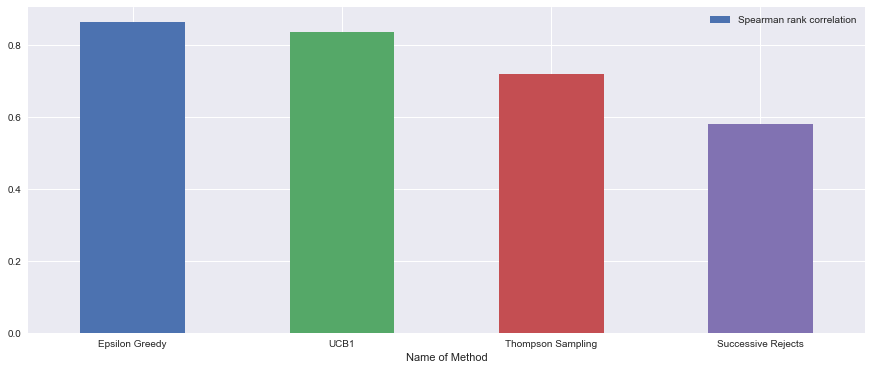

In [66]:
df_cor.plot.bar(x='Name of Method', y='Spearman rank correlation', rot=0);